<a href="https://colab.research.google.com/github/Belhoussine/Breast-Cancer-Recognition-ML/blob/master/Breast_Cancer_Recognition_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import csv
import gc
import cv2

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))
def read_csv(filename):
  metadata=list()
  with open(filename) as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
      metadata.append(row)
  return metadata
if __name__ == "__main__":
  imageSize=512
  ''' Helper Map '''
  abnormalityToNum= {'NORM': 0, 'CALC': 1, 'CIRC': 2, 'SPIC': 3, 'MISC':4, 'ARCH':5, 'ASYM':6}
  numToAbnormality= {0:'NORM', 1:'CALC', 2:'CIRC', 3:'SPIC', 4:'MISC', 5:'ARCH', 6:'ASYM'}

  ''' Metadata Pre-processing'''
  csvPath="/content/drive/My Drive/metadata.csv"
  metadata=read_csv(csvPath)
  labels=set()
  for data in metadata:
    labels.add((data[0],data[2]))
  labels=[i[1] for i in sorted(labels)]
  train_labels=[abnormalityToNum[i] for i in labels]

  ''' Image Pre-processing '''
  pgmPath="/content/drive/My Drive/MIAS Database/"
  pgmNames= sorted(os.listdir(pgmPath))
  images= list()
  for pgm in pgmNames:
    image=read_pgm(str(pgmPath+pgm))
    images.append(cv2.resize(image, (imageSize,imageSize)))
  images = np.asarray(images)
  train_img = images / 255.0
  train_img=train_img.reshape((-1, imageSize, imageSize,1))

[0 1 2 3 4 5 6]


In [9]:
from sklearn.utils import compute_class_weight
classWeight = compute_class_weight('balanced', np.unique(train_labels), train_labels) 
classWeight = dict(enumerate(classWeight))

model = keras.Sequential(
    [keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(imageSize,imageSize,1)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation= 'relu'),
    keras.layers.Dense(7, activation='softmax')]
)
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_img, train_labels,epochs=20, class_weight=classWeight)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 322 samples
Epoch 1/20
322/322 [==============================] - 113s 351ms/sample - loss: 1.9914 - acc: 0.1398
Epoch 2/20
322/322 [==============================] - 110s 342ms/sample - loss: 1.9224 - acc: 0.3634
Epoch 3/20
322/322 [==============================] - 110s 342ms/sample - loss: 1.9088 - acc: 0.2826
Epoch 4/20
322/322 [==============================] - 110s 342ms/sample - loss: 1.8257 - acc: 0.2453
Epoch 5/20
322/322 [==============================] - 109s 340ms/sample - loss: 1.7797 - acc: 0.2950
Epoch 6/20
322/322 [==============================] - 109s 339ms/sample - loss: 1.7097 - acc: 0.2298
Epoch 7/20
322/322 [==============================] - 110s 341ms/sample - loss: 1.6121 - acc: 0.3199
Epoch 8/20
322/322 [==============================] - 110s 343ms/sample - loss: 1.5081 - acc: 0.3199
Epoch 9/20
322/322 [==============================] - 109s 339ms/sample - loss: 1.4467 - a

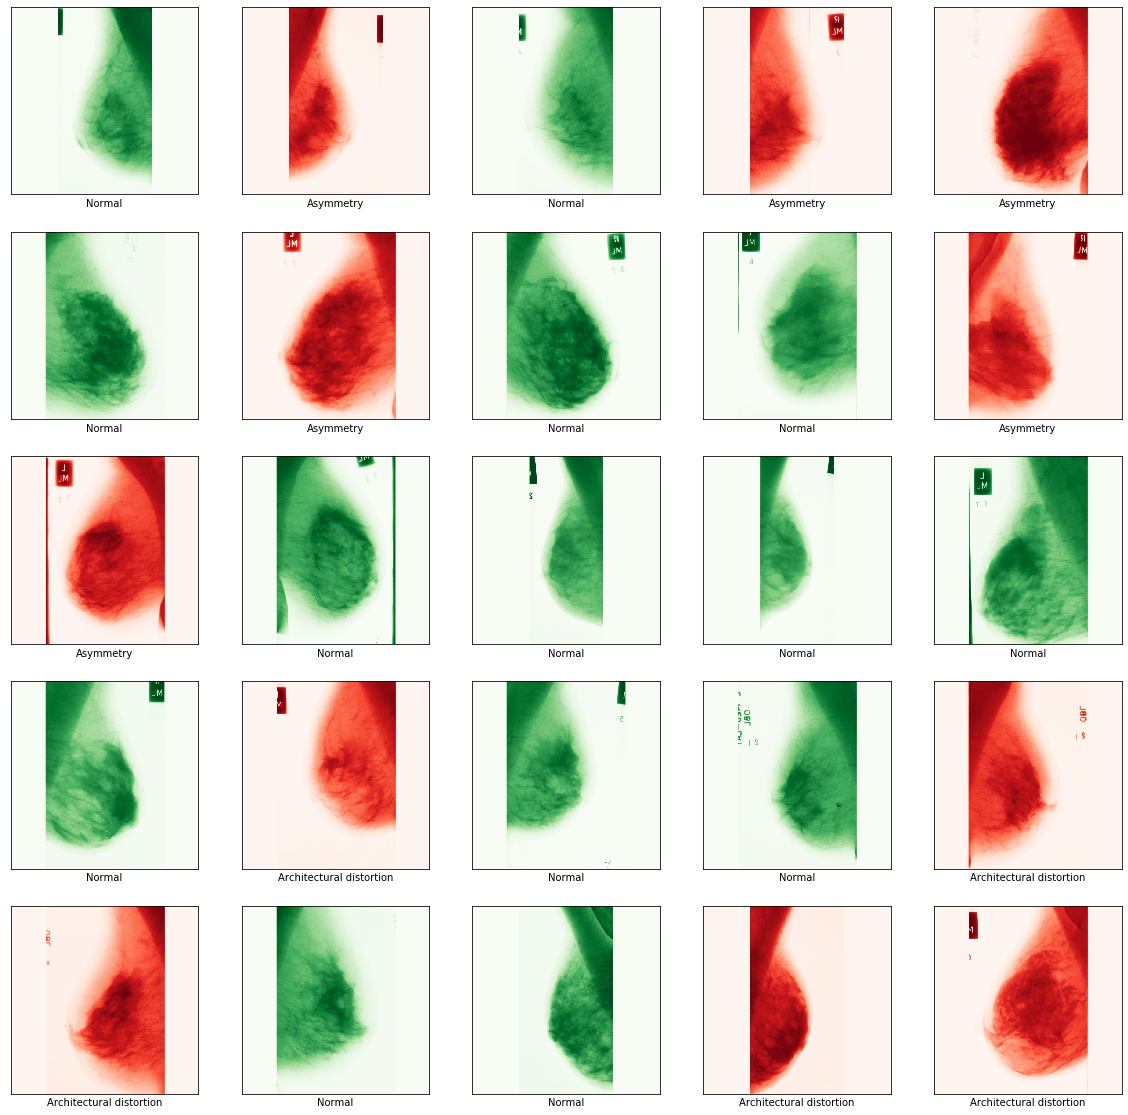

In [63]:
'''cnt=0
for i in range (10):
  prediction= np.argmax(model.predict(np.expand_dims(train_img[i],0)))
  if(numToAbnormality[prediction] == numToAbnormality[train_labels[i]]):
    cnt+=1
print(cnt/322.0)'''
abnormToDef={"NORM":"Normal","CALC":"Calcification", "CIRC": " Well-defined/circumscribed masses", "SPIC":"Spiculated masses", "MISC":"ill-defined masses", "ARCH":"Architectural distortion", "ASYM":"Asymmetry"}
plt.figure(figsize=(20,20))
start= 100
for i in range(start, start+25):
    k = i- start
    ax=plt.subplot(5,5,k+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    prediction= np.argmax(model.predict(np.expand_dims(train_img[i],0)))
    if(numToAbnormality[prediction] == "NORM"):
      plt.imshow(np.squeeze(train_img[i]), cmap="Greens")
    else:
      plt.imshow(np.squeeze(train_img[i]), cmap="Reds")
    if(numToAbnormality[prediction] == "NORM"):
      norm=plt.xlabel(abnormToDef[numToAbnormality[prediction]])
    else: 
      abnorm=plt.xlabel(abnormToDef[numToAbnormality[prediction]])

plt.show()